In [2]:
from MAUtil import *
from MAInit import *
from MACalc import *
from MAPost import *
import re
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

plt.rcParams["font.size"] = 14
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
figs = [20,50]
fign = [15,4]

In [3]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)

In [4]:
db = client.adsE_database
collection = db.adsE_collection

### prepare data for prediction ###

In [5]:
elements = ['Ag', 'Al', 'Au', 'Cu', 'Pt', 'Pd', 'Ni', 'Rh']
faces = ['100', '111', '110', '211']

dictlis = []

for ele in elements:
    for face in faces:
        dicte = {'element':ele, 'face':face}
        dictlis.append(dicte)

dictlis.append({'element':'Ru', 'face':'001'})
dictlis.append({'element':'Ru', 'face':'100'})
dictlis.append({'element':'Zn', 'face':'001'})
dictlis.append({'element':'Zn', 'face':'100'})

dictlis.append({'element':'ZnCu', 'face':'100'})
dictlis.append({'element':'ZnCu', 'face':'110'})
dictlis.append({'element':'CuSn', 'face':'100'})
dictlis.append({'element':'CuSn', 'face':'001'})
dictlis.append({'element':'CoPt3', 'face':'100'})
dictlis.append({'element':'GaNi', 'face':'110'})

In [6]:
inst = []
dfall = []
df = []
dfpred = []

for i in range(len(dictlis)):
    try:
        du = dataset_utilizer('adsE_method2', **dictlis[i])
        inst.append(du)
        dfall.append(du.dfall)
        df.append(du.df)
        dfpred.append(du.dfpred)
    except:
        print('Error: {0}'.format(dictlis[i]))

In [7]:
covset = []
for i in range(len(dfpred)):
    covset.append(sorted(list(set(dfpred[i]['coverage']))))
# covset

### Just show residue ####

Ag 100 0.0005342570298262968
Ag 111 0.011850904695467183
Ag 110 0.0017850343711218802
Ag 211 0.0007326723823899933
Al 100 0.0014839438099084684
Al 111 0.005244707578313854
Al 110 0.0004726681792073698
Al 211 0.007804176047608113
Au 100 0.0037093252912995946
Au 111 0.05542613418480541
Au 110 0.0019495413268498885
Au 211 0.002706175409236848
Cu 100 0.006861210661829148
Cu 111 0.010012355734378198
Cu 110 0.0075831651359413955
Cu 211 8.512381906147112e-05
Pt 100 0.032045708411087136
Pt 111 0.04920174986573488
Pt 110 0.061758228783154734
Pt 211 0.0029665607399163717
Pd 100 0.03909728288145137
Pd 111 0.03706626383249074
Pd 110 0.041641567282464376
Pd 211 0.0016137967875358558
Ni 100 0.011266270322570857
Ni 111 0.012401751111926268
Ni 110 0.004929312352677112
Ni 211 0.0006128383645314014
Rh 100 0.006378257188467971
Rh 111 0.007950089271624888
Rh 110 0.009724748115559385
Rh 211 0.006200056631138052
Ru 001 0.007537677999186248
Ru 100 0.015211689802338538
Zn 100 0.009387853122751158
ZnCu 100 0.0

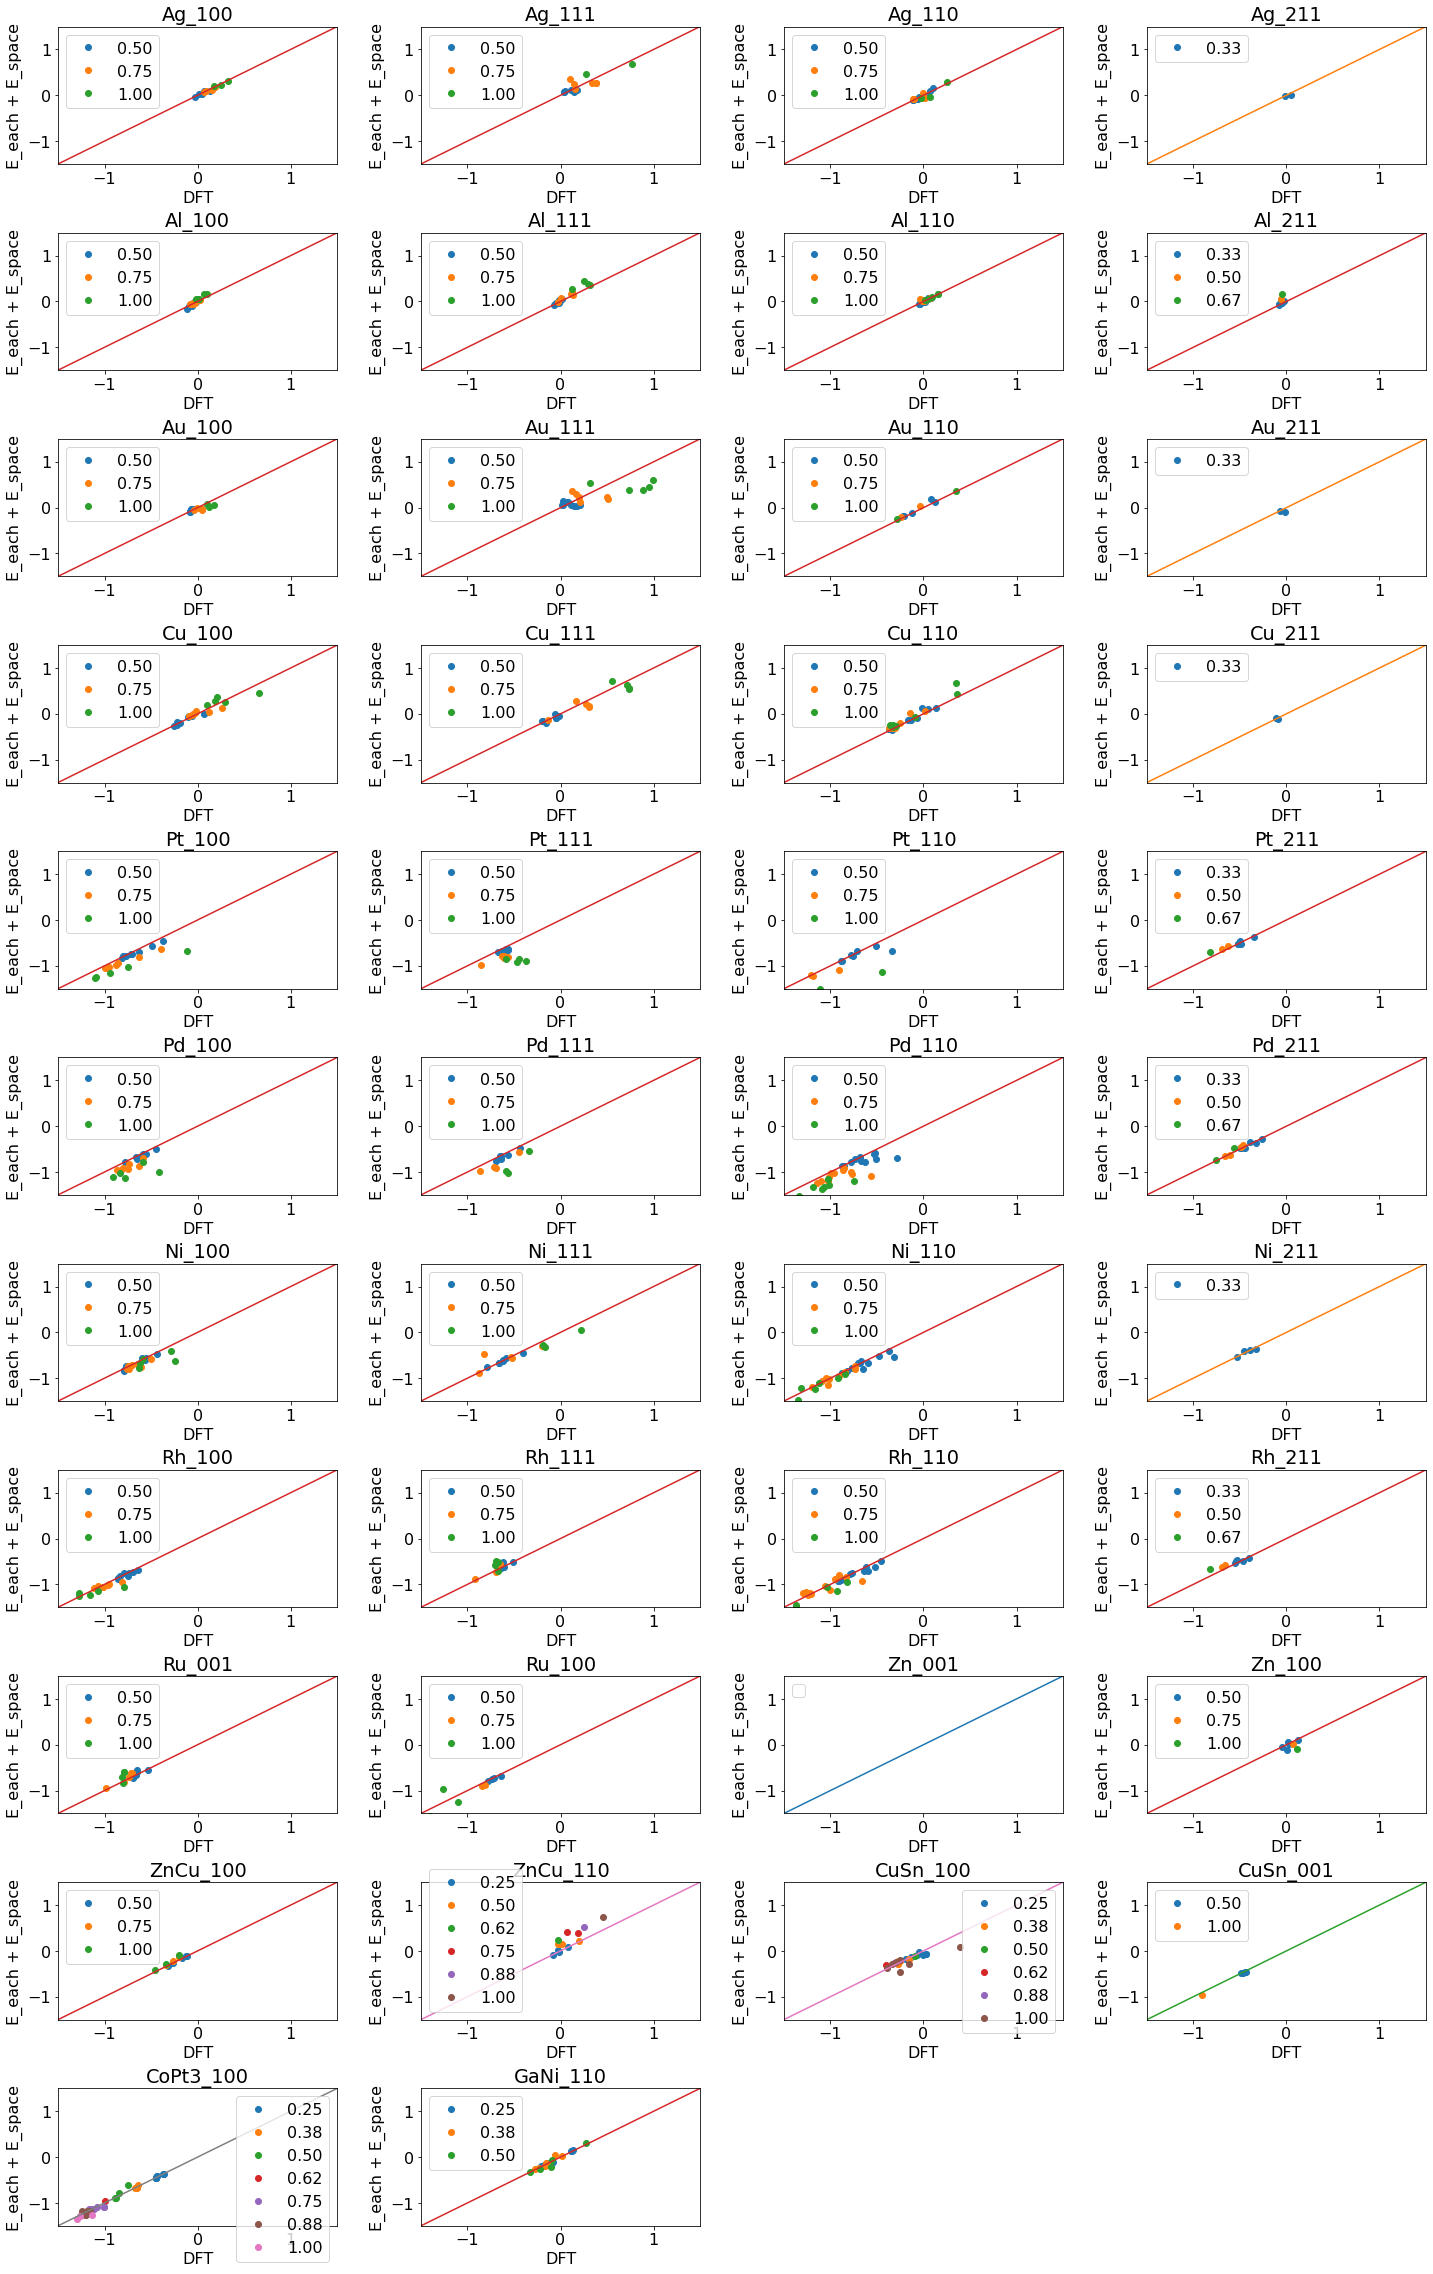

In [7]:
xrange = np.linspace(-2, 2)
# predadsene_surf, adsElis, Eint
fig = plt.figure(figsize=(figs[0],figs[1]))
plt.rcParams["font.size"] = 16

for i in range(len(dfpred)):
    ax = fig.add_subplot(fign[0],fign[1], i+1)
    xmin = 100
    xmax = -100

    for j in range(len(covset[i])):
        if not covset[i][j]:
            continue
        data = dfpred[i][dfpred[i]['coverage'] == covset[i][j]]
        aveadsE_suratom = np.array(data['aveadsE/suratom'])
        E_residue = np.array(data['E_residue/suratom'])
        E_prepred = aveadsE_suratom - E_residue
        if not aveadsE_suratom.any():
            continue
        if xmin > np.min(aveadsE_suratom):
            xmin = np.min(aveadsE_suratom)
        if xmax < np.max(aveadsE_suratom):
            xmax = np.max(aveadsE_suratom)
        ax.plot(aveadsE_suratom, E_prepred, 'o')
   
    ax.plot(xrange, xrange, '-')

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
#     ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]])
    ax.set_xlabel('DFT')
    ax.set_ylabel('E_each + E_space')
#     plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    
    if not covset[i]:
        continue
    data = dfpred[i]
    aveadsE_suratom = np.array(data['aveadsE/suratom'])
    E_residue = np.array(data['E_residue/suratom'])
    E_prepred = aveadsE_suratom - E_residue    
    print(dictlis[i]['element'], dictlis[i]['face'], mean_squared_error(aveadsE_suratom, E_prepred))
    
# plt.savefig('E_residue.png', bbox_inches='tight')
plt.show()

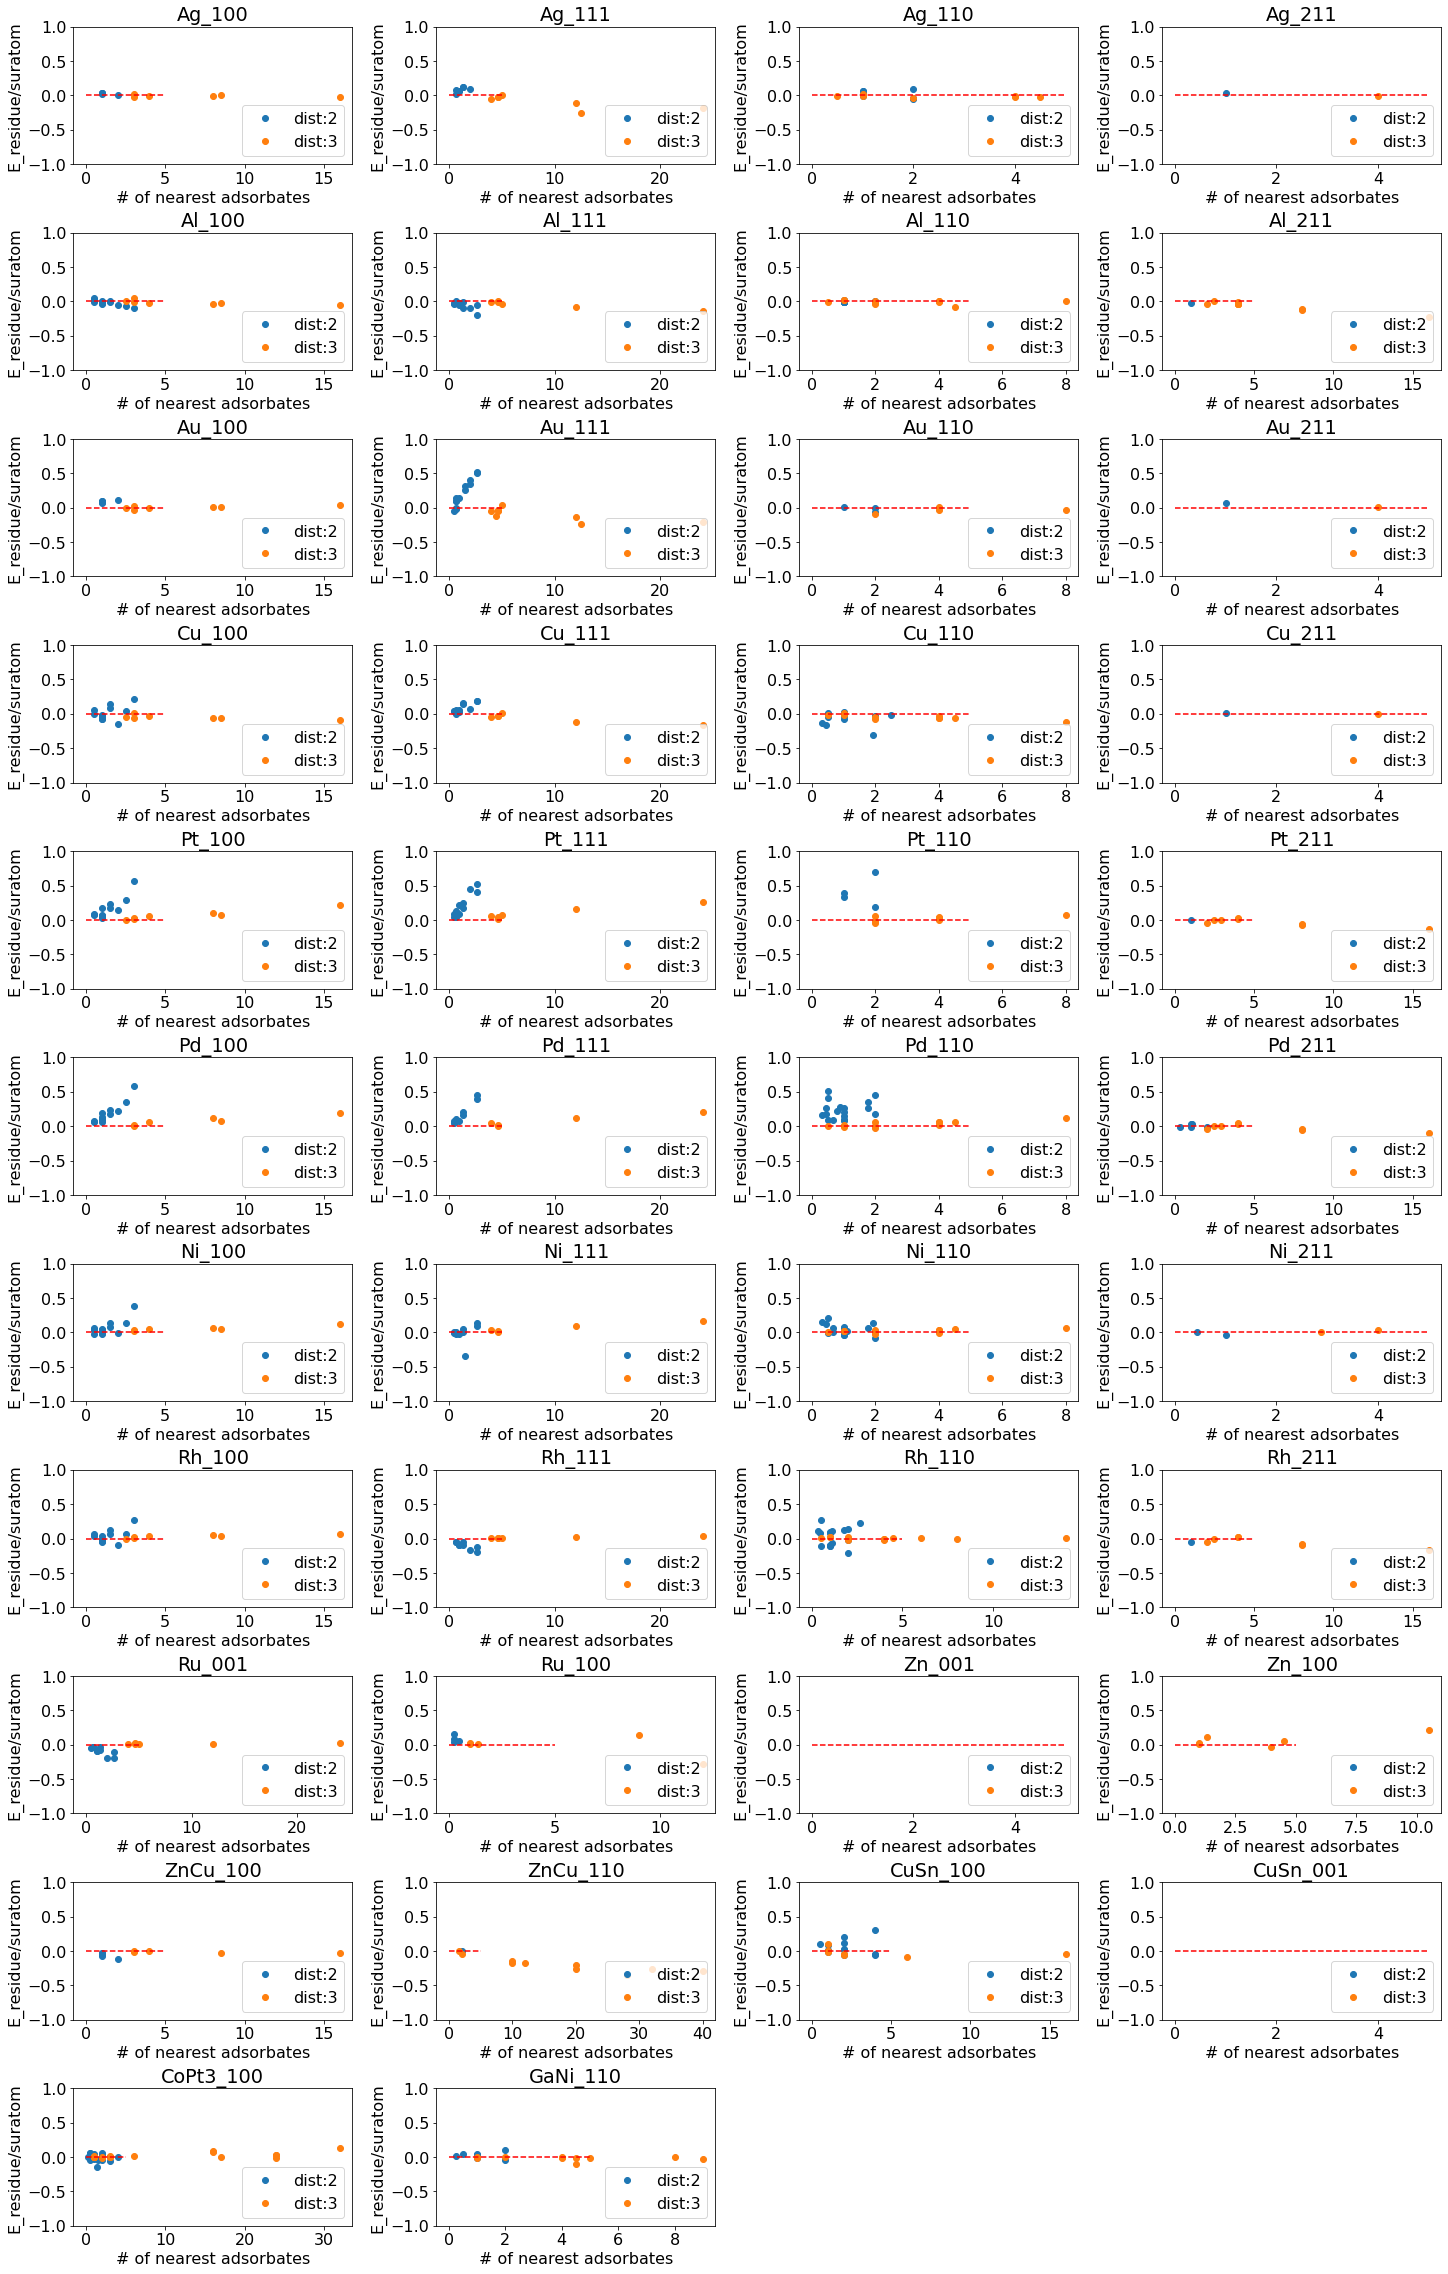

In [8]:
fig = plt.figure(figsize=(figs[0],figs[1]))
plt.rcParams["font.size"] = 16


xmin = 0
xmax = 5
for i in range(len(dfpred)):
    ax = fig.add_subplot(fign[0],fign[1], i+1)
    ax.plot(dfpred[i][dfpred[i]['minimum_distance']==2]['ads_dist2'], dfpred[i][dfpred[i]['minimum_distance']==2]['E_residue/suratom'], 'o')
    ax.plot(dfpred[i][dfpred[i]['minimum_distance']==3]['ads_dist3'], dfpred[i][dfpred[i]['minimum_distance']==3]['E_residue/suratom'], 'o')
    ax.plot([xmin,xmax],[0,0], "red", linestyle='dashed') # normal way
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
    ax.set_xlabel('# of nearest adsorbates')
    ax.set_ylabel('E_residue/suratom')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    plt.legend(['dist:2','dist:3'], loc='lower right')
# plt.savefig('')
  #  plt.xlim(xmin,xmax)
    plt.ylim(-1,1)
plt.show()

### Parameters are specific to material and face

Ag 100 0.0002735556505493786 0.0233927117155994 -0.0008789206455014601 0.00782224047592699 0.000807070854765492
Ag 111 0.001959621554928864 0.12451407733867072 -0.009218314970286377 0.017399233192246063 0.0014477718349590679
Ag 110 0.0015082689512084621 0.01932469652376835 -0.004933245294878807 0.012043564970862265 0.003978922616080165
Ag 211 2.407412430484045e-35 0.039434637499999585 -0.0020006741666670123 inf inf
Al 100 0.0007007715219569622 -0.014527658416896221 -0.002316465259944394 0.006075023553006505 0.0011368053302188528
Al 111 0.0012749201119582824 -0.02296416538007827 -0.004744422379048623 0.00915329868922716 0.001196188065575856
Al 110 0.00042207975182799044 0.003089566395141241 -0.0021763628611737172 0.00674155534545942 0.0014629866491471715


/home/katsuyut/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1620: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


Al 211 0.0005166624082107427 -0.005935896287119918 -0.01297214371287955 0.025155671385438217 0.0011539177397613942
Au 100 0.0003311736041961835 0.06459780506354719 0.0015253946514975658 0.008523990610741876 0.0008758404192893085
Au 111 0.004130826816931287 0.22742891095968554 -0.009505130288468581 0.015638628406850517 0.0018646279223920078
Au 110 0.0015648754536962744 -0.010189459565575341 -0.0030556244631150453 0.0164457669847327 0.0038525959457237162
Au 211 1.504632769052528e-34 0.07142772416666611 0.0017912275000000492 inf inf
Cu 100 0.003312213952606037 0.048066716654456915 -0.010148742776864172 0.013416462661364948 0.0024818835857948734
Cu 111 0.0008458639424442038 0.09607302339239782 -0.006610945307707783 0.007545359166907145 0.0009785293391816952
Cu 110 0.004729840394419825 -0.02751522619479267 -0.011462957128707946 0.015605613547146577 0.004720774983335328
Cu 211 0.0 0.011058002500001926 -0.002451795833332032 inf inf
Pt 100 0.005525045450452887 0.11017149937304889 0.00699027335

/home/katsuyut/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1620: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
/home/katsuyut/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1620: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


Pt 111 0.001713277245964155 0.12682265471391224 0.010805922842364582 0.010490815812148474 0.00138131951292654
Pt 110 0.008667385644049392 0.20462491473765881 0.018683068755144517 0.03643942655176818 0.0072589075204021105
Pt 211 0.0008352319159595298 0.011344665196712612 -0.006639770196720568 0.032807629732873815 0.0015719295326651445
Pd 100 0.0038955376729337484 0.12653937577252983 0.007153614134334666 0.014615915108647837 0.002713707430386617
Pd 111 0.0009824070599621702 0.12317735560228077 0.00815239010581285 0.008459237644908017 0.0011687982424497293
Pd 110 0.010342547156842423 0.1264196649796065 0.02297747304392094 0.02872455966988474 0.006569958864803445
Pd 211 0.000688793686661984 0.021714944843948383 -0.005141672704959929 0.011818991749327325 0.0013382372924507795
Ni 100 0.005137388847410858 0.05746312490254435 0.0021218941328557507 0.016686559782026 0.0031072545871182666
Ni 111 0.010809463886810576 -0.012529245331558837 0.005242145451445075 0.027060169414016153 0.00384147920860

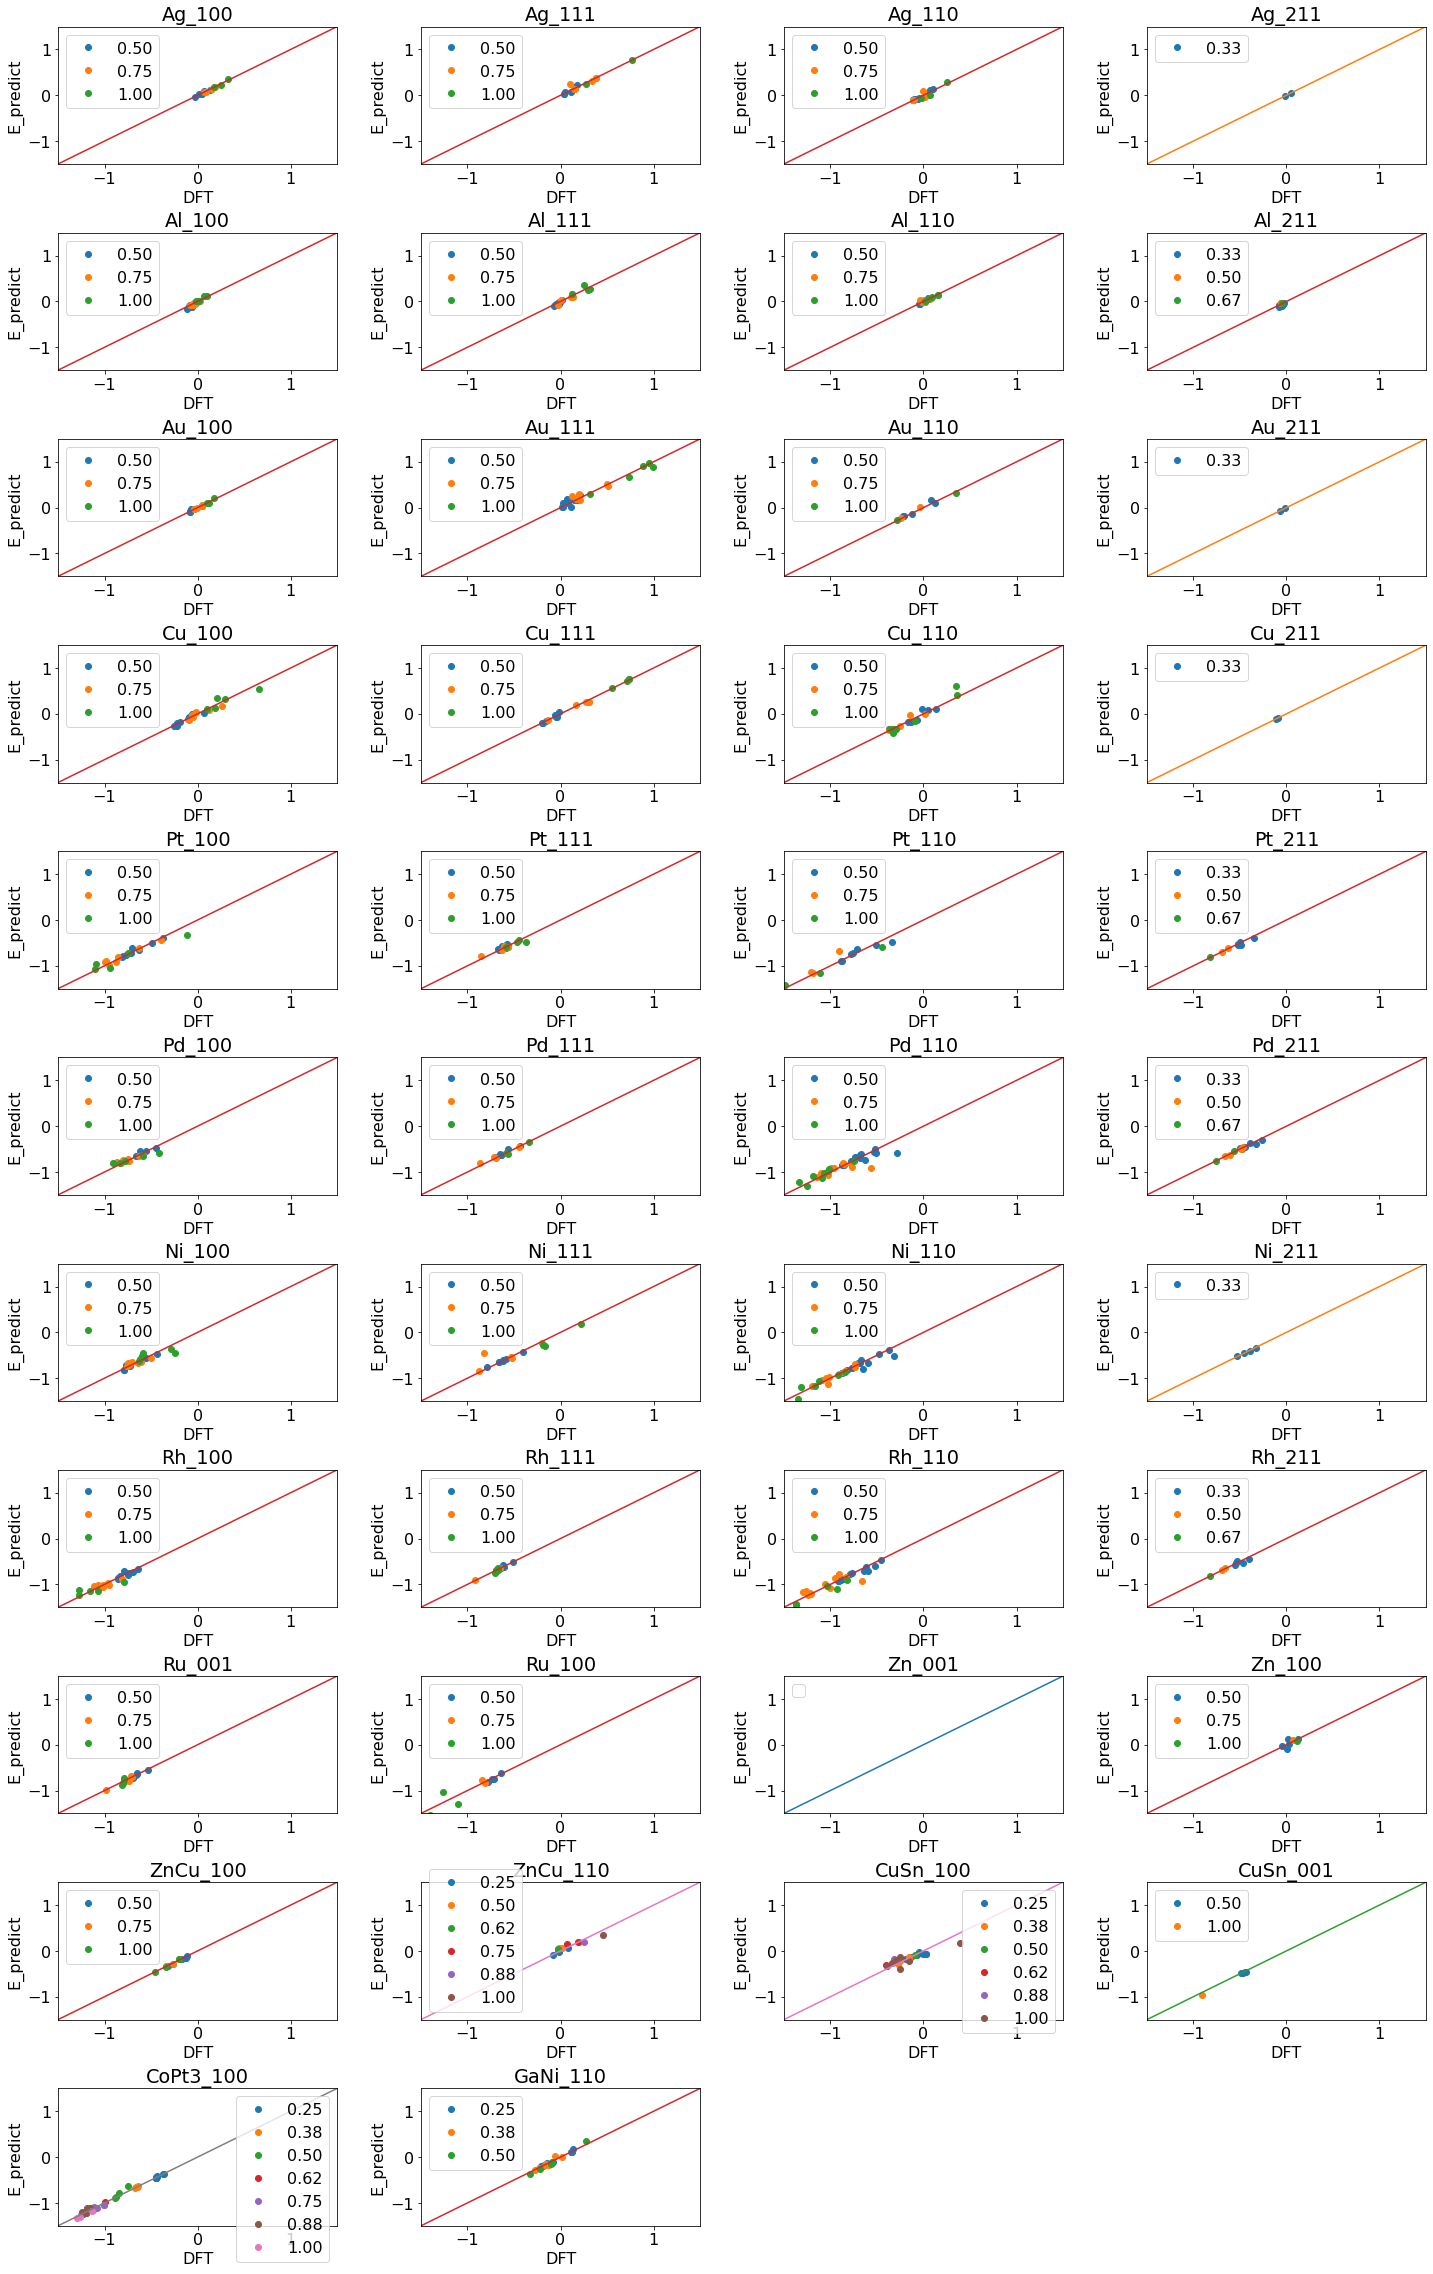

In [14]:
xrange = np.linspace(-2, 2)
# predadsene_surf, adsElis, Eint
fig = plt.figure(figsize=(figs[0],figs[1]))
plt.rcParams["font.size"] = 16
mselis = []
weightslis = []
std_errslis = []

for i in range(len(dfpred)):
    ax = fig.add_subplot(fign[0],fign[1], i+1)
    xmin = 100
    xmax = -100
    try:
        weights, std_errs = inst[i].fit_weight_from_specific_element_and_face()
        weightslis.append(weights)
        std_errslis.append(std_errs)
    except:
        weightslis.append(np.array([0,0]))
        std_errslis.append(np.array([0,0]))
        print('Data unusable')

    for j in range(len(covset[i])):
        data = dfpred[i][dfpred[i]['coverage'] == covset[i][j]]

        E_residue_pred = data['ads_dist2'] * weights[0] + data['ads_dist3'] * weights[1]
        E_ads_pred = (data['E_int_space'] + data['sumE_each_ads'])/data['surfatomnum'] + E_residue_pred

        aveadsE_suratom = data['aveadsE/suratom']
        if not aveadsE_suratom.any():
            continue
        if xmin > np.min(aveadsE_suratom):
            xmin = np.min(aveadsE_suratom)
        if xmax < np.max(aveadsE_suratom):
            xmax = np.max(aveadsE_suratom)
        ax.plot(aveadsE_suratom, E_ads_pred, 'o')
    ax.plot(xrange, xrange, '-')

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
#     ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]])
    ax.set_xlabel('DFT')
    ax.set_ylabel('E_predict')
#     plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    
    if not covset[i]:
        continue
    data = dfpred[i]
    E_residue_pred = data['ads_dist2'] * weights[0] + data['ads_dist3'] * weights[1]
    E_ads_pred = (data['E_int_space'] + data['sumE_each_ads'])/data['surfatomnum'] + E_residue_pred
    aveadsE_suratom = data['aveadsE/suratom']
    mse = mean_squared_error(aveadsE_suratom, E_ads_pred)
    mselis.append(mse)
    print(dictlis[i]['element'], dictlis[i]['face'], mse, *weights, *std_errs)

weightslis = np.array(weightslis)
std_errslis = np.array(std_errslis)
# plt.savefig('E_pred_wmf_method3.png', bbox_inches='tight')
# plt.show()

In [22]:
labels = []

for i in range(len(dfpred)):
    labels.append(dictlis[i]['element'] +' '+ dictlis[i]['face'])
# dictlis[i]['element'], dictlis[i]['face']

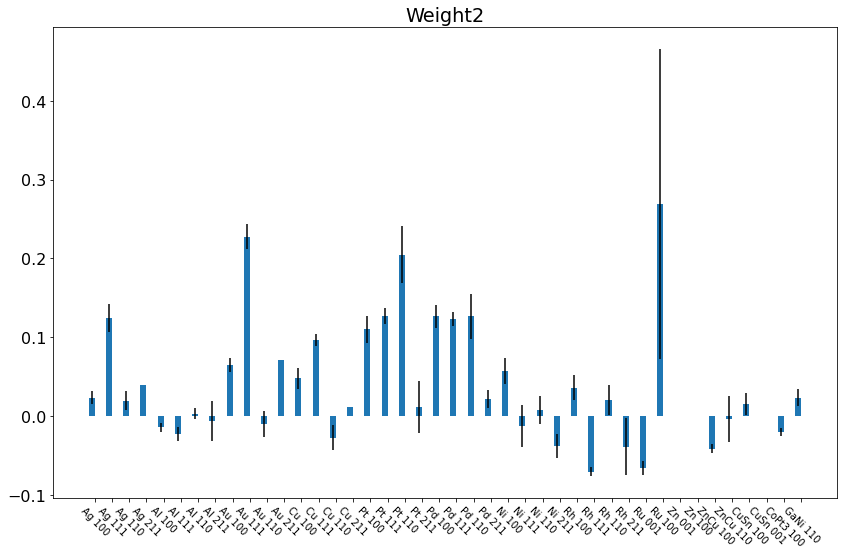

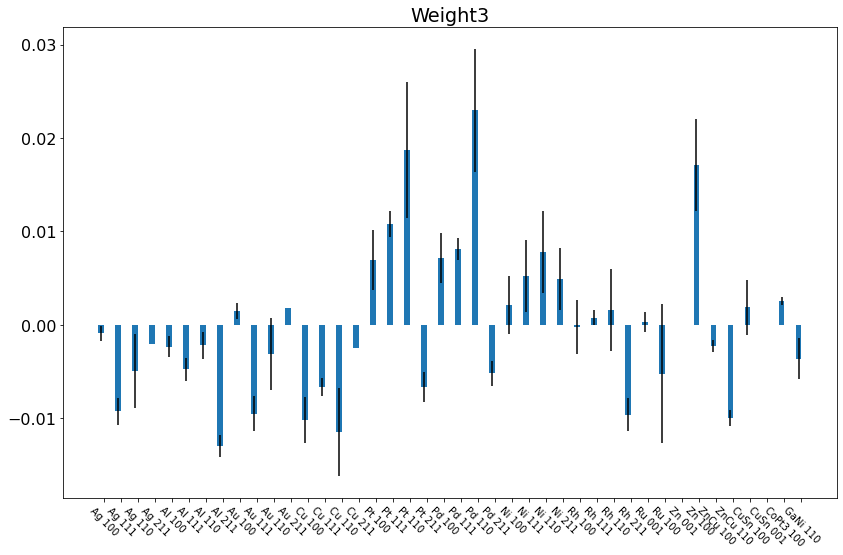

In [23]:
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, weightslis[:,0], width, yerr = std_errslis[:,0])

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('weight2')
ax.set_title('Weight2')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=-45, fontsize=10)

fig.tight_layout()
plt.width = 10

plt.show()


fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, weightslis[:,1], width, yerr = std_errslis[:,1])

# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('weight2')
ax.set_title('Weight3')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=-45, fontsize=10)

fig.tight_layout()
plt.width = 10

plt.show()

### Parameters are only specific to material

Ag 100 0.0002735556505493786 0.0233927117155994 -0.0008789206455014601 0.00782224047592699 0.000807070854765492
Ag 111 0.008292734412039138 0.028513407572284585 -0.0014596044697596984 0.00673156063376428 0.0007388847715408671
Ag 110 0.0017455020716403387 0.02541212191134917 -0.0012419606806924313 0.007875352929523221 0.0008087927069832836
Ag 211 4.647167699115274e-05 0.04794639724332038 -0.0012946428881470305 0.00802155500395558 0.00045884301794104124
Al 100 0.0007007715219569622 -0.014527658416896221 -0.002316465259944394 0.006075023553006505 0.0011368053302188528
Al 111 0.0021141274006453736 -0.014854049635897973 -0.002292694433181621 0.0063534900788065 0.001169283502594408
Al 110 0.0006478278292877267 -0.014527658416896221 -0.002316465259944394 0.005945579762783732 0.0011125828083792207
Al 211 0.005167762297802934 -0.014162837722761883 -0.002586086293107976 0.00620741031407089 0.0011352815436381182
Au 100 0.0003311736041961835 0.06459780506354719 0.0015253946514975658 0.008523990610

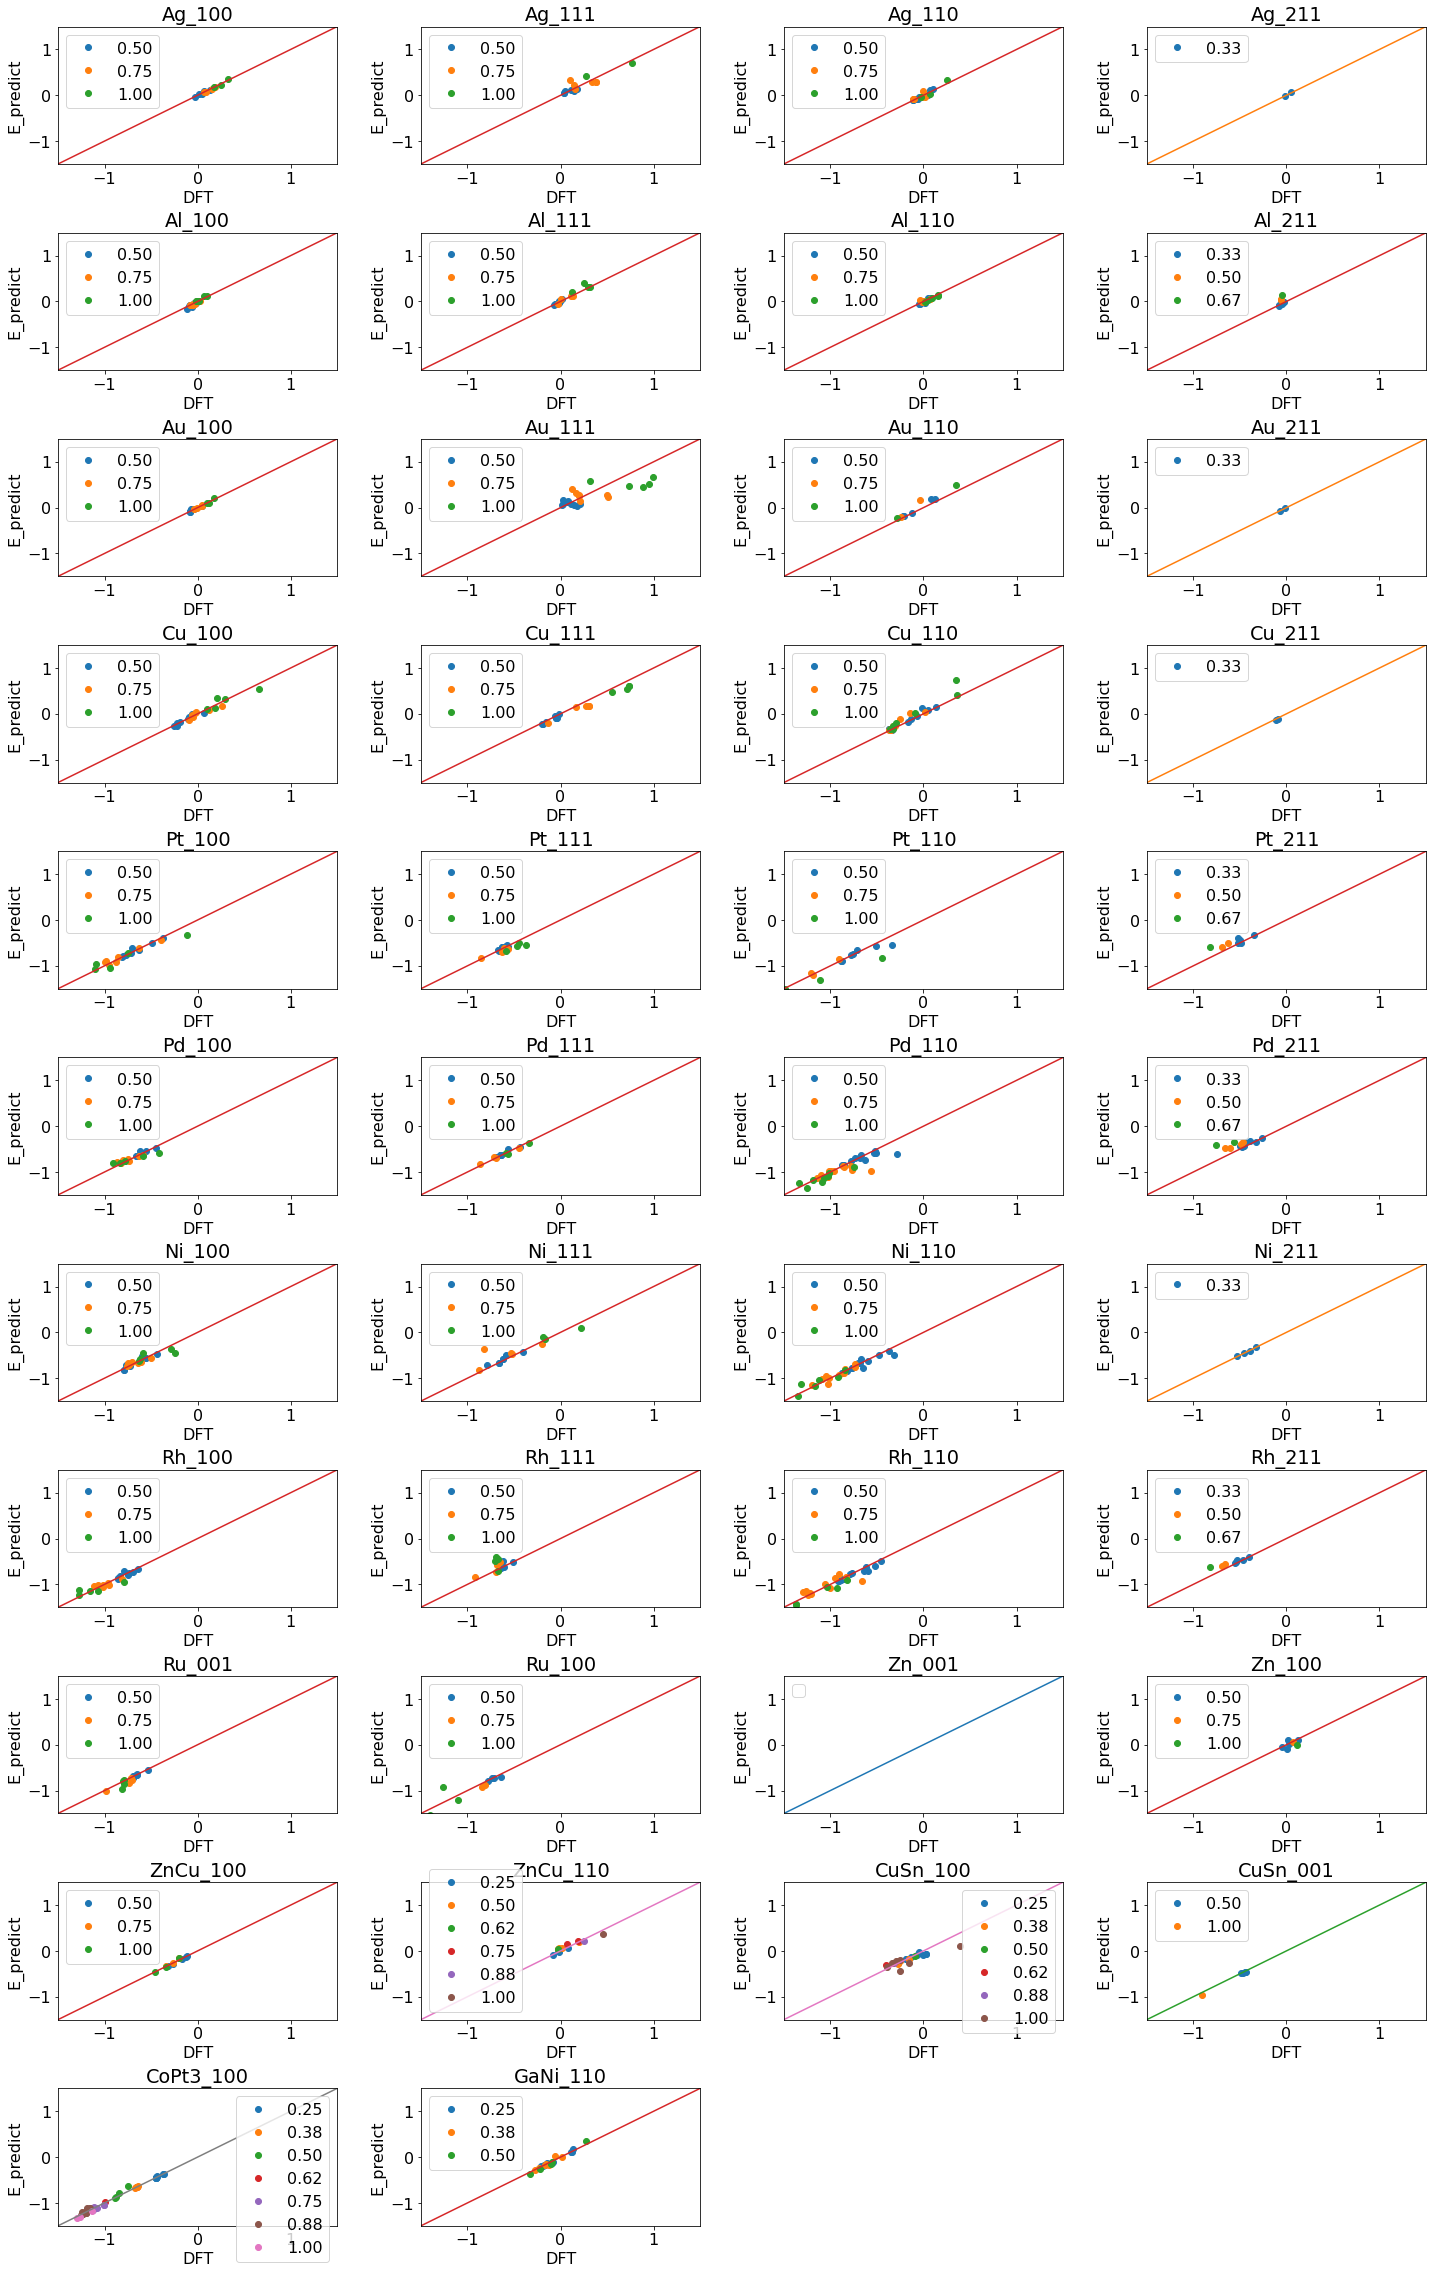

In [15]:
xrange = np.linspace(-2, 2)
# predadsene_surf, adsElis, Eint
fig = plt.figure(figsize=(figs[0],figs[1]))
plt.rcParams["font.size"] = 16

for i in range(len(dfpred)):
    ax = fig.add_subplot(fign[0],fign[1], i+1)
    xmin = 100
    xmax = -100
    try:
        weights, std_errs = inst[i].fit_weight_from_specific_element()
    except:
        print('Data unusable')

    for j in range(len(covset[i])):
        data = dfpred[i][dfpred[i]['coverage'] == covset[i][j]]
        E_residue_pred = data['ads_dist2'] * weights[0] + data['ads_dist3'] * weights[1]
        E_ads_pred = (data['E_int_space'] + data['sumE_each_ads'])/data['surfatomnum'] + E_residue_pred

        aveadsE_suratom = data['aveadsE/suratom']
        if not aveadsE_suratom.any():
            continue
        if xmin > np.min(aveadsE_suratom):
            xmin = np.min(aveadsE_suratom)
        if xmax < np.max(aveadsE_suratom):
            xmax = np.max(aveadsE_suratom)
        ax.plot(aveadsE_suratom, E_ads_pred, 'o')
    ax.plot(xrange, xrange, '-')

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
#     ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]])
    ax.set_xlabel('DFT')
    ax.set_ylabel('E_predict')
#     plt.savefig('{}_{}_predE_wCObondfix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.5, wspace=0.3)
    
    if not covset[i]:
        continue
    data = dfpred[i]
    E_residue_pred = data['ads_dist2'] * weights[0] + data['ads_dist3'] * weights[1]
    E_ads_pred = (data['E_int_space'] + data['sumE_each_ads'])/data['surfatomnum'] + E_residue_pred
    aveadsE_suratom = data['aveadsE/suratom']    
    print(dictlis[i]['element'], dictlis[i]['face'], mean_squared_error(aveadsE_suratom, E_ads_pred), *weights, *std_errs)

# plt.savefig('E_pred_wm_method2.png', bbox_inches='tight')
# plt.show()

In [30]:
dfall[-5][dfall[-5]['numberofads']==1]

,_id,name,isvalid,ispredictable,element,face,unitlength,xc,adsorbate,numberofads,coverage,surfatomnum,E,bareE,E_ads,totaladsE,aveadsE/suratom,aveadsE/ads,E_int_space,sumE_each_ads,E_residue/suratom,area,density,igroups,rgroups,converged,is_adsorbed,kept_sites,E_not_exceeded,minimum_distance,ads_dist2,ads_dist3
0,5e87991a6636fa78ec7c4157,ZnCu_110_u2_RPBE_no001_CO_n1_d10.traj,yes,no,ZnCu,110,2,RPBE,CO,1,0.125,8,-75.334788,-60.917344,-14.485436,0.067993,0.008499,0.067993,0.003343,NaN,NaN,51.150813,0.01955,[0],[0],yes,yes,yes,yes,Over 4,0.0,0.000000
1,5e8799236636fa78ec7c4159,ZnCu_110_u2_RPBE_no002_CO_n1_d10.traj,yes,no,ZnCu,110,2,RPBE,CO,1,0.125,8,-75.758751,-60.917344,-14.485436,-0.355970,-0.044496,-0.355970,0.003343,NaN,NaN,51.150813,0.01955,[1],[1],yes,yes,yes,yes,Over 4,0.0,0.000000
2,5e87992d6636fa78ec7c415b,ZnCu_110_u2_RPBE_no003_CO_n1_d10.traj,yes,no,ZnCu,110,2,RPBE,CO,1,0.125,8,-75.099534,-60.917344,-14.485436,0.303246,0.037906,0.303246,0.003343,NaN,NaN,51.150813,0.01955,[2],[2],yes,yes,yes,yes,3,0.0,0.125000
3,5e8799366636fa78ec7c415d,ZnCu_110_u2_RPBE_no005_CO_n1_d10.traj,yes,no,ZnCu,110,2,RPBE,CO,1,0.125,8,-75.496489,-60.917344,-14.485436,-0.093708,-0.011714,-0.093708,0.003343,NaN,NaN,51.150813,0.01955,[4],[4],yes,yes,yes,yes,3,0.0,0.125000
4,5e87993f6636fa78ec7c415f,ZnCu_110_u2_RPBE_no006_CO_n1_d10.traj,no,no,ZnCu,110,2,RPBE,CO,1,0.125,8,-75.735599,-60.917344,-14.485436,-0.332819,-0.041602,-0.332819,0.003646,NaN,NaN,51.150813,0.01955,[5],[1],yes,yes,no,yes,Over 4,0.0,0.000000
5,5e8799496636fa78ec7c4161,ZnCu_110_u2_RPBE_no007_CO_n1_d10.traj,no,no,ZnCu,110,2,RPBE,CO,1,0.125,8,-75.493520,-60.917344,-14.485436,-0.090740,-0.011342,-0.090740,0.003646,NaN,NaN,51.150813,0.01955,[6],[4],yes,yes,no,yes,3,0.0,0.222222
43,5e94eac5e371cf722a147139,ZnCu_110_u2_RPBE_no004_CO_n1_d10.traj,no,no,ZnCu,110,2,RPBE,CO,1,0.125,8,-75.740920,-60.917344,-14.485436,-0.338140,-0.042267,-0.338140,0.003735,NaN,NaN,51.150813,0.01955,[3],[1],yes,yes,no,yes,Over 4,0.0,0.000000


In [35]:
init_query('ZnCu_110_u2_RPBE_no004_CO_n1_d10.traj','local')
query('ZnCu_110_u2_RPBE_no004_CO_n1_d10.traj','local')

Atoms(symbols='Zn2Cu2Zn2Cu2Zn2Cu2Zn2Cu2Zn2Cu2Zn2Cu2Zn2Cu2Zn2Cu2CO', pbc=[True, True, False], cell=[[6.0140740590921835, 0.0, 4e-16], [1.4e-15, 8.505185099484375, 5e-16], [0.0, 0.0, 25.51555529845313]], tags=..., constraint=FixAtoms(indices=[0, 1, 2, 3, 8, 9, 10, 11, 16, 17, 18, 19, 24, 25, 26, 27]), calculator=SinglePointCalculator(...))

In [10]:
dfpred[-1]

,_id,name,isvalid,ispredictable,element,face,unitlength,xc,adsorbate,numberofads,coverage,surfatomnum,E,bareE,E_ads,totaladsE,aveadsE/suratom,aveadsE/ads,E_int_space,sumE_each_ads,E_residue/suratom,area,density,igroups,rgroups,converged,is_adsorbed,kept_sites,E_not_exceeded,minimum_distance,ads_dist2,ads_dist3
0,5e7ea294c7c11c30f5560128,GaNi_110_u2_RPBE_no002_CO_n2_d6.traj,yes,yes,GaNi,110,2,RPBE,CO,2,0.250,8,-156.917009,-126.29995,-14.485436,-1.646186,-0.205773,-0.823093,-0.002659,-1.601861,-0.005208,49.038087,0.040785,"[1, 1]","[1, 1]",yes,yes,yes,yes,Over 4,0.00,0.000
1,5e7ea2a1c7c11c30f556012c,GaNi_110_u2_RPBE_no003_CO_n3_d3.traj,yes,yes,GaNi,110,2,RPBE,CO,3,0.375,8,-171.934087,-126.29995,-14.485436,-2.177828,-0.272228,-0.725943,0.268258,-2.402792,-0.005412,49.038087,0.061177,"[1, 1, 1]","[1, 1, 1]",yes,yes,yes,yes,3,0.00,4.000
2,5e7ea2afc7c11c30f5560130,GaNi_110_u2_RPBE_no004_CO_n4_d3.traj,yes,yes,GaNi,110,2,RPBE,CO,4,0.500,8,-186.864848,-126.29995,-14.485436,-2.623153,-0.327894,-0.655788,0.550522,-3.203722,0.003756,49.038087,0.081569,"[1, 1, 1, 1]","[1, 1, 1, 1]",yes,yes,yes,yes,3,0.00,8.000
3,5e7ea2bec7c11c30f5560134,GaNi_110_u2_RPBE_no005_CO_n3_d3.traj,yes,yes,GaNi,110,2,RPBE,CO,3,0.375,8,-170.983423,-126.29995,-14.485436,-1.227164,-0.153396,-0.409055,0.043620,-1.113386,-0.019675,49.038087,0.061177,"[4, 1, 1]","[4, 1, 1]",yes,yes,yes,yes,3,0.00,4.500
4,5e7ea2e4c7c11c30f5560138,GaNi_110_u2_RPBE_no006_CO_n4_d3.traj,yes,yes,GaNi,110,2,RPBE,CO,4,0.500,8,-184.984245,-126.29995,-14.485436,-0.742550,-0.092819,-0.185637,0.106005,-0.624911,-0.027956,49.038087,0.081569,"[4, 4, 1, 1]","[4, 4, 1, 1]",yes,yes,yes,yes,3,0.00,9.000
5,5e7ea2f2c7c11c30f556013c,GaNi_110_u2_RPBE_no007_CO_n2_d6.traj,yes,yes,GaNi,110,2,RPBE,CO,2,0.250,8,-156.715917,-126.29995,-14.485436,-1.445095,-0.180637,-0.722547,0.272998,-1.601861,-0.014529,49.038087,0.040785,"[1, 1]","[1, 1]",yes,yes,yes,yes,3,0.00,4.000
6,5e7ea2fec7c11c30f556013e,GaNi_110_u2_RPBE_no008_CO_n3_d3.traj,yes,yes,GaNi,110,2,RPBE,CO,3,0.375,8,-171.582845,-126.29995,-14.485436,-1.826586,-0.228323,-0.608862,0.269259,-2.153536,0.007211,49.038087,0.061177,"[2, 1, 1]","[2, 1, 1]",yes,yes,yes,yes,3,0.00,2.000
7,5e7ea30ac7c11c30f5560140,GaNi_110_u2_RPBE_no009_CO_n4_d3.traj,yes,yes,GaNi,110,2,RPBE,CO,4,0.500,8,-186.012478,-126.29995,-14.485436,-1.770783,-0.221348,-0.442696,0.551700,-2.705211,0.047841,49.038087,0.081569,"[2, 2, 1, 1]","[2, 2, 1, 1]",yes,yes,yes,yes,2,1.00,4.000
8,5e7ea316c7c11c30f5560142,GaNi_110_u2_RPBE_no010_CO_n2_d6.traj,yes,yes,GaNi,110,2,RPBE,CO,2,0.250,8,-156.807238,-126.29995,-14.485436,-1.536416,-0.192052,-0.768208,0.004993,-1.601861,0.007557,49.038087,0.040785,"[1, 1]","[1, 1]",yes,yes,yes,yes,Over 4,0.00,0.000
9,5e7ea393c7c11c30f556014c,GaNi_110_u2_RPBE_no016_CO_n3_d3.traj,yes,yes,GaNi,110,2,RPBE,CO,3,0.375,8,-169.643366,-126.29995,-14.485436,0.112893,0.014112,0.037631,0.043618,0.176020,-0.013343,49.038087,0.061177,"[4, 4, 1]","[4, 4, 1]",yes,yes,yes,yes,3,0.00,5.000
